## Hyperplane folding.

The following code runs the algorithm from the paper:
*Hyperplane folding - a way to increase the margin in Support Vector Machines
*Lars Lundberg, Håkan Lennerstad, Eva Garcia-Martin, Niklas Lavesson and Veselka Boeva

It does the following:
1. Apply SVM in a dataset
2. Select the primary support vector
3. Divide the points into two, ones to the left of the support vector (forming an orthogonal line with the hyperplane) and the other ones to the right of the support vector
4. Apply two SVM on each new set of points
5. Rotate one side an angle a. 
6. The margin has thus increased from the initial one. 

In [1]:
"""
Simulation functions
"""

def generate_point(center, radius):
    #Generate a random vector on the unit circle (length 1)
    ang = uniform(0, 2*pi)
    v = np.array([cos(ang), sin(ang)])
 
    # Generate a normally distributed length
    #(mean = 0, so the length can be negative)
    l = radius + 1
    while abs(l) > radius:
        l = normalvariate(0, radius)
    return center + l * v


def generate_points(centers, points_per_circle, radius):
    X = list()
    Y = list()
    count = 1
    
    for center in centers:
        for i in range(points_per_circle):
            X.append(generate_point(center, radius))
            if count%2:
                Y.append(0)
            else:
                Y.append(1)
        count += 1
        
    X=np.array(X)
    Y=np.array(Y)
    return (X,Y)

def get_margin(clf):
    w = clf.coef_[0]
    a = -w[0] / w[1]
    s_vectors = clf.support_vectors_
    intrc_up = (s_vectors[-1][1] - a * s_vectors[-1][0])
    intrc_down = (s_vectors[0][1] - a * s_vectors[0][0])
    margin = (abs(intrc_up - intrc_down))/(math.sqrt(1+(a*a)))
    return margin

def plot_SVM(clf,x,y, should_plot):
    if should_plot: 
        w = clf.coef_[0]
        a = -w[0] / w[1]
        xx = np.linspace(x[:,0].min(),x[:,0].max())
        intercept = -(clf.intercept_[0]) / w[1]
        s_vectors = clf.support_vectors_

        # Margin
        intrc_up = (s_vectors[-1][1] - a * s_vectors[-1][0])
        intrc_down = (s_vectors[0][1] - a * s_vectors[0][0])
        yy = a * xx + intercept
        yy_up = a * xx + intrc_up
        yy_down = a * xx + intrc_down

#         pdf = PdfPages('SVM' + str(time.clock()) + '.pdf')
#         fig=figure(figsize=(6,4))
        
        plt.plot(xx, yy, 'k-')
        plt.plot(xx, yy_down, 'k--')
        plt.plot(xx, yy_up, 'k--')

        plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],s=80, facecolors='none')
        plt.scatter(x[:, 0], x[:, 1], c=y, cmap=plt.cm.Paired)
        plt.axis('tight')
        plt.show()
        
#         pdf.savefig(fig) # note the format='pdf' argument!
#         pdf.close()
    
def get_support_vector(X, Y, supp):
    
    s=0
    supp_v=0
    for i in supp:
        s += Y[i]
    for n in supp:
        if Y[n] == 1 and s == 1:
            return X[n]
        if Y[n] == 0 and s== 2:
            return X[n]
        
def point_vs_othline(point, supp,  a ): 
    t= (point[0] - supp[0])/(-a)
    if point[1] <= supp[1] + t:
        return "higher/right"
    else:
        return "lower/left"
    
def splitting (X,Y, clf, prime_sv):
    r"""
    Splitting the points in X and Y, based on an orthogonal line to the hyperplane
    obtained by the classifier clf
    
    return: both sets of points
    """
    set1x=list()
    set2x=list()
    set1y=list()
    set2y=list()
    # In case there are more than 1 point with the same value as the support vector, so that we don't add it twice.
    already_added = False
    
#     for item in clf.n_support_:
#         suppsum+=item
    if len(clf.support_vectors_) == 3: 
        w = clf.coef_[0]
        a = -w[0] / w[1]
        i=0
        for item in X:
            if (item[0]==prime_sv[0]) and (item[1]==prime_sv[1]) and already_added == False:
                set1x.append(item)
                set1y.append(Y[i])
                set2x.append(item)
                set2y.append(Y[i])
                already_added = True
            elif point_vs_othline(item,prime_sv,a ) == "higher/right":
                set2x.append(item)
                set2y.append(Y[i])
            elif point_vs_othline(item,prime_sv,a) == "lower/left":
                set1x.append(item)
                set1y.append(Y[i])
            else:
                print("There is something wrong. Point is not either higher nor lower")
            i+=1
    else:
        raise Exception('More than 3 Support Vectors. N of SV: ', suppsum )
    return [set1x, set1y, set2x, set2y]


def folding_point(clf1, clf2):
    
    w1 = clf1.coef_[0]
    a1 = -w1[0] / w1[1]
    intercept1= -(clf1.intercept_[0]) / w1[1]
    
    w2 = clf2.coef_[0]
    a2 = -w2[0] / w2[1]
    intercept2= -(clf2.intercept_[0]) / w2[1]
    
    xf = (intercept2-intercept1)/(a1-a2)
    yf = xf*a1 + intercept1
    
    angle = np.arctan(a1) - np.arctan(a2)
    return [xf,yf] , angle
    
def remove_supp (sx, sy, supp):
    
    index=0
    while sx[index][0] != supp[0] and sx[index][1] != supp[1]:
        index+=1
    sx = np.delete(sx,index, 0)
    sy = np.delete(sy,index)
    
    return sx,sy
    
def points_folded(X, f_point, angle):
    
    i=0
    XR = np.zeros(X.shape)
    # 1. 2. and 3.
    for item in X:
        XR[i][0] = item[0] - f_point[0] 
        XR[i][1] = item[1] - f_point[1]
        
        x_p = np.cos(angle)*XR[i][0] - np.sin(angle)*XR[i][1]
        y_p = np.sin(angle)*XR[i][0] + np.cos(angle)*XR[i][1]
        
        XR[i][0] = x_p + f_point[0]
        XR[i][1] = y_p + f_point[1]
        i+=1
    return XR

def get_clf():
    """
    Return the classifier, so that we can test different classifiers and not only one
    We don't need to change the instance everywhere, which outputs many errors due to the manual
    change that it requires. 

    """
     
#     C = 1000000000
    return svm.SVC(kernel='linear', C=0.1) 
#     return svm.NuSVC(kernel='linear', nu=0.0000001) 

def folding(x,y,clf, plot = True):
    """
    Gets the main support vector. 
    Divides the dataset into 2,based on the orthogonal line 
    to the plane and the main support vector. 
    Apply SVM on both sides, rotate the one with the greatest margin. 
    We need to remove the support vector, since it is repeated.
    """
    prime_sv = get_support_vector(x,y, clf.support_)
    set1x, set1y, set2x, set2y = splitting (x, y, clf, prime_sv)
    
    
    clf_s1 = get_clf()
    clf_s1.fit(set1x, set1y)
    margin1 = get_margin(clf_s1)
    
    clf_s2 = get_clf()
    clf_s2.fit(set2x, set2y)
    margin2 = get_margin(clf_s2)
    
    
    f_point, angle = folding_point(clf_s1, clf_s2)
    
    print("prime sv: " , prime_sv)
    
    if margin1 > margin2: 
        part_folded = "left"
        set1x_nosupp, set1y_nosupp = remove_supp (np.array(set1x), set1y, prime_sv)
        XR = points_folded(set1x_nosupp, f_point, -angle)
        x_folded = np.concatenate((XR, np.array(set2x))) 
        y_folded = np.concatenate ((np.array(set1y_nosupp),np.array(set2y)))
        
        
    else:
        part_folded = "right"
        set2x_nosupp, set2y_nosupp = remove_supp (np.array(set2x), set2y, prime_sv)
        XR = points_folded(set2x_nosupp, f_point, angle)
        x_folded = np.concatenate((np.array(set1x), XR)) 
        y_folded = np.concatenate ((np.array(set1y), np.array(set2y_nosupp)))
        
#         print "X_FOLDED 2: ", x_folded , "\n Y_FOLDED 2: ", y_folded
    
    if plot:
        print("\nSVM Set 1: LEFT")
        plot_SVM(clf_s1, np.array(set1x), set1y,plot)
        print("\nSVM Set 2: RIGHT")
        plot_SVM(clf_s2, np.array(set2x), set2y ,plot)
        
    return angle, part_folded, x_folded, y_folded, prime_sv, f_point

def plot_points(x,y, should_plot):
    if should_plot:
        pdf = PdfPages('points' + str(time.clock()) + '.pdf')
        
        fig=figure(figsize=(6,4))
        plt.scatter(x[:, 0], x[:, 1], c=y, cmap=plt.cm.Paired)
        plt.axis('tight')
        plt.show()
        pdf.savefig(fig) # note the format='pdf' argument!
        pdf.close()
        
def remove_extra_sv(clf):
    # We remain with the first three
    # Need to change also dual_coef_ to remove the SVs > 3. 
    # Then coef_ will be changed automatically. 
    if len(clf.support_vectors_) > 3:
        clf.support_vectors_ = clf.support_vectors_[0:3]
        clf.dual_coef_ = clf.dual_coef_[0,0:3]
        clf.dual_coef_ = clf.dual_coef_.reshape((1,-1))
        
    return clf

In [2]:
def load_dataset(filename):
    dataset = pd.read_csv('../../datasets/'+filename)
    return dataset

In [19]:
# The function projects the points when there are 3 SV. I try to code it for other values. In progress.
# 3 : Number of dimensions. 
def project_3SV(X,clf):
    dim = 3
    n_sv = len(clf.support_vectors_)
    m = n_sv - 1
    w = np.zeros((m,dim))
    W = np.zeros((m,dim))
    for i in range(1,n_sv):
        w[i-1] = clf.support_vectors_[i] - clf.support_vectors_[0]
        
    # Not sure why we need this, but I am following the formula
    W = w
    
    # Gram-Schmidt. Need to find a way to program it for diferent SV than 3...
    fm = np.zeros((m,dim))
    fm[0] = W[0]
    fm[1] = W[1] - (np.dot(fm[0],W[1]) / np.dot(fm[0], fm[0]) * fm[0])
    
    # f3. We need to obtain f3, as an orthogonal vector to fm1, fm2. Then we normalize all 3 to become fn. 
    # With H eq. z always set to 1 atm.
    f3 = [0,0,0]
    x, y, z = symbols('x y z')
#     print("SOLVER: ")
    eq = (solve([Eq(fm[0][0]*x + fm[0][1]*y + fm[0][2]*z, 0), 
           Eq(fm[1][0]*x + fm[1][1]*y + fm[1][2]*z, 0),
           Eq(z,1)],[x, y,z]))
    
    f3[0] = eq[x]
    f3[1] = eq[y]
    f3[2] = eq[z]
    
    # Orthonormal: fn. I need one more dimension. n=number of dimensions. n = 3
    # Q? We need to find fn[2] before normalizing?
    fn = np.zeros((dim,dim))
    fn[0] =  fm[0] / np.sqrt(math.pow(fm[0][0],2) + math.pow(fm[0][1],2) + math.pow(fm[0][2],2))    
    fn[1] =  fm[1] / np.sqrt(math.pow(fm[1][0],2) + math.pow(fm[1][1],2) + math.pow(fm[1][2],2))
    fn[2] =  f3 / np.sqrt(math.pow(f3[0],2) + math.pow(f3[2],2) + math.pow(f3[2],2))
    
    print("fm: ", fm)
    print("fn NORMALIZED: ", fn)
    
    # 4. Form a n   n-matrix P where f1 ; :::; fn are column vectors. 
    # This gives the rotation matrix R = P T (transpose). So basically the same as having fn as row vectors
    # that is exactly what we have. 
    
    rot_matx = fn 
    
    # 5. Move the origin to v1; i.e. add  v1 to all points.
    X = X - clf.support_vectors_[0]
    X_projected = pd.DataFrame(columns=X.columns)
    for index, row in X.iterrows():
        newpoint = np.dot(rot_matx,row.transpose())
        X_projected.loc[index] = newpoint
    
    return X_projected

    
def project_4SV(X,clf):
    # Calculating distance. Need to check all the SV, check the shortest distance for each pair. 
    d1 = abs(np.linalg.norm(clf.support_vectors_[0]-clf.support_vectors_[1])) 
    d2 = abs(np.linalg.norm(clf.support_vectors_[2]-clf.support_vectors_[3]) )

    v = clf.support_vectors_[0]
    u = clf.support_vectors_[1]
    
    if d1 > d2:
        v = clf.support_vectors_[2]
        u = clf.support_vectors_[3]
  
    print("v: ", v, " u: ", u)
    w = v - u
    
    print("w: ", w)
    W = np.linalg.norm(w)
    print("W: ", W)
    W_12 = np.linalg.norm(w[:2])
    print("W12: ", W_12)

    cosTheta = (w[2])/W
    sinTheta = W_12/W

#     R = [[None for y in range(0,3)] for x in range (0,3)]
    R = [[ ((w[2]/W) + (w[1]**2 * (1-(w[2]/W))/W_12**2)) , -w[0]*w[1]*(1-(w[2]/W))/W_12**2, -w[0]/W],
         [-w[0]*w[1] * ((1-(w[2]/W))/W_12**2), w[2]/W + (w[0]**2*(1-(w[2]/W))/W_12**2), -w[1]/W], 
         [w[0]/W , w[1]/W, w[2]/W]]
    
    
    X_projected = pd.DataFrame(columns=X.columns)
    for index, row in X.iterrows():
        newpoint = np.dot(R,row.transpose())
        X_projected.loc[index] = newpoint
    
    return X_projected


def project_points(dataset):
    """
    Projecting the points from 3D to 2D, so that they are orthogonal to the Z axis.
    Håkan Lennerstad's formulas
    
    1. Apply SVM on dataset
    2. Get pair of support vectors
    3. Choose the pair with the minumum distance 
    """
    
    X = dataset.iloc[:,:3]
    Y = dataset['class']
    clf = get_clf()
    clf.fit(X, Y)
    
    print("Supp Vs when trying to project", clf.support_vectors_)
    print("Number of SVs", len(clf.support_vectors_))

    
    if len(clf.support_vectors_) == 3:
        X_projected = project_3SV(X,clf)
        print("3 SVs")
    else:
        X_projected = project_4SV(X,clf)
        print("4 Support Vectors")
        # If we have more than 4: We take 2 from each class. 
        
    print ("X initial points: \n\n" , X)
    print ("\nX Projected points: \n\n" , X_projected)
    Z = X_projected.iloc[:,2]
#     print "\nZ component: \n", Z
    X_projected = X_projected.iloc[:,0:2]
    print ("\nX Projected points after removing Z : \n\n" , X_projected)
    
    return X_projected, Z

In [18]:
# Simulation: Training. 

def training(X_projected, Y, Z, iterations):
    """
    Training SVM on dataset
    """
    print("\nStarting training in 2D")
    # Dictionary that saves the information of every rotation
    folding_info = dict()
    
    # Data
    angle, part_folded, x_folded, y_folded, prime_sv, f_point = None, None, None, None, None, None
    should_plot = True

    d_x = np.array(X_projected)
    d_y = np.array(Y)
    d_z = np.array(Z)

#     for i in range(0,iterations+1): 
    for i in range(0,iterations): 
        
        # 1. SVM, margin and plot of the initial points. 
        clf = get_clf() 
        clf.fit(d_x, d_y)
        margin = get_margin(clf)
        
        # Remove extra support vectors
        clf = remove_extra_sv(clf)
        
        if i==0:
            print("\nInitial SVM. No folding yet.  Initial Margin: {:f}".format(margin))
        else:
            print("Iteration: ", i)
            
        plot_SVM(clf,d_x, d_y, should_plot)
        
        # 2. Folding. 
        angle, part_folded, x_folded, y_folded, prime_sv, f_point = folding(d_x, d_y, clf)

        folding_info[str(i)] = {'margin': margin, 'clf': clf, 'angle': angle, 
                           'part':part_folded, 'x_folded': x_folded, 
                           'y_folded': y_folded, 'prime_support_vector': prime_sv,
                           'f_point': f_point}
        
        print("Folding point: ", f_point)
        # 3. SVM on the folded points, to check the margin increase. Plot it
        clf = get_clf() 
        clf.fit(x_folded, y_folded)
        margin = get_margin(clf)
        print("Folding {:d} . Folding the {:s}. New margin: {:f}".format(i+1,part_folded, margin))
        plot_SVM(clf,x_folded, y_folded, should_plot)


        # 4. Add the Z component. Create the dataset with the same format as before
        df_dict = {'f1': x_folded[:,0], 
                   'f2': x_folded[:,1],
                   'f3': d_z,
                   'class': y_folded}
        
        dataset_after_folding = pd.DataFrame(data=df_dict, columns = ['f1', 'f2', 'f3', 'class'])
        print ("New points after folding {:d} times \n".format(i+1), dataset_after_folding)
        
        # 5. Rotate and project the points again. These will be the initial points for the next round.  
        X_projected, Z = project_points(dataset_after_folding)
        
        # Project points again 
        d_x = np.array(X_projected)
        # Y stays the same: y_folded
        d_y = np.array(y_folded)
        d_z = np.array(Z) 

In [15]:
# Simulation: Testing
# Need to do the same rotations that we did for training, and keep track of it. 


def testing(dataset):
    print("Testing: Not doing anything atm")
    

Supp Vs when trying to project [[ 100.    0.   60.]
 [ 100.  200.   60.]
 [   0.  100.   90.]
 [ 200.  100.   90.]]
Number of SVs 4
v:  [ 100.    0.   60.]  u:  [ 100.  200.   60.]
w:  [   0. -200.    0.]
W:  200.0
W12:  200.0
4 Support Vectors
X initial points: 

      f1   f2   f3
0     0    0    0
1   100    0   60
2   200    0    0
3     0  100    0
4   100  100   10
5   200  100    0
6     0  200    0
7   100  200   60
8   200  200    0
9     0    0  150
10  100    0  150
11  200    0  150
12    0  100   90
13  100  100  140
14  200  100   90
15    0  200  150
16  100  200  150
17  200  200  150

X Projected points: 

        f1     f2     f3
0     0.0    0.0    0.0
1   100.0   60.0    0.0
2   200.0    0.0    0.0
3     0.0    0.0 -100.0
4   100.0   10.0 -100.0
5   200.0    0.0 -100.0
6     0.0    0.0 -200.0
7   100.0   60.0 -200.0
8   200.0    0.0 -200.0
9     0.0  150.0    0.0
10  100.0  150.0    0.0
11  200.0  150.0    0.0
12    0.0   90.0 -100.0
13  100.0  140.0 -100.0
14  200.

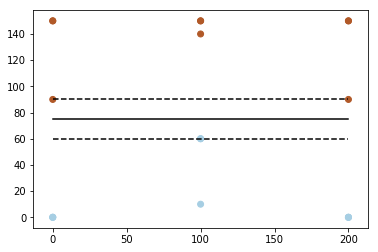

prime sv:  [ 100.   60.]

SVM Set 1: LEFT


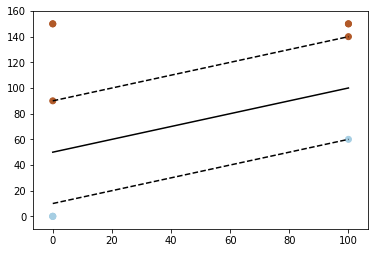


SVM Set 2: RIGHT


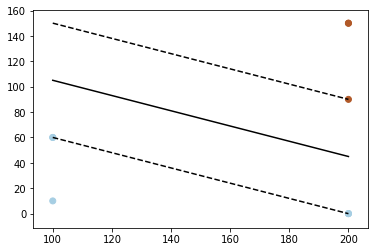

Folding point:  [104.56411329089356, 102.28682580223074]
Folding 1 . Folding the right. New margin: 71.565246


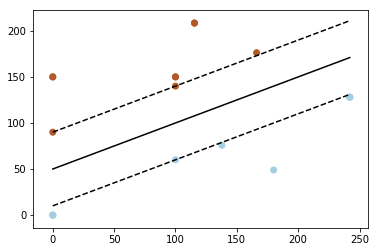

New points after folding 1 times 
             f1          f2     f3  class
0     0.000000    0.000000    0.0      0
1   100.000000   60.000000    0.0      0
2     0.000000    0.000000    0.0      0
3     0.000000    0.000000 -100.0      0
4     0.000000  150.000000 -100.0      1
5   100.000000  150.000000 -100.0      1
6     0.000000   90.000000 -200.0      1
7   100.000000  140.000000 -200.0      1
8     0.000000  150.000000 -200.0      1
9   100.000000  150.000000    0.0      1
10  242.084476  127.953009    0.0      0
11  179.998168   48.925860    0.0      0
12  242.084476  127.953009 -100.0      0
13  137.802237   75.749421 -100.0      0
14  242.084476  127.953009 -100.0      0
15  115.496684  208.423692 -200.0      1
16  166.131801  176.235419 -200.0      1
17  115.496684  208.423692 -200.0      1
Supp Vs when trying to project [[ 137.80223739   75.74942063 -100.        ]
 [ 100.          140.         -200.        ]
 [ 100.          150.            0.        ]]
Number of SVs 3
fm:

In [23]:
########################################
####             MAIN               ####
#### 30th June 2017                 ####
#### 3D case for hyperplane folding ####
#### 1. Projecting                  ####
#### 2. 2D case                     ####
########################################


# Import necessary packages
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
import math
import pandas as pd
from sklearn import datasets
from random import randint
from matplotlib.backends.backend_pdf import PdfPages
import time
from pylab import *
from sympy import *

def main():
    iterations=1
    
    # Dataset
    dataset = load_dataset('toy_dataset_3D.csv')
    Y = dataset['class']

    # Project the points
    X_projected, Z = project_points(dataset)
   
    # Training 2D
    training(X_projected, Y, Z, iterations)

    # Testing 2D
    testing(dataset)

    
if __name__ =='__main__':
    main()